In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from causaldag import UndirectedGraph
import itertools
from sklearn import preprocessing
import pickle
from gsp import gsp_stability_selection
from graphviz_plotting import plot_graphviz_style_graph
import os
from IPython.display import Image

%matplotlib inline

In [ ]:
# Functions
def choose_stable_variables(stability_scores, bootstrap_threshold=0.5):
    """Returns adjacency matrix corresponding to edges with stability scores above threshold."""
    return (stability_scores.max(axis=0) > bootstrap_threshold).astype('float')


def get_directed_and_undirected_edges(adjacency_matrix):
    """
    Given an adjacency matrix, which contains both directed and undirected edges,
    this function returns two adjancy matrices containing directed and undirected edges separately.
    Useful for plotting the difference causal graph.
    Parameters
    ----------
    adjacency_matrix: array, shape  = [num_nodes, num_nodes]
        Adjacency matrix representing partially directed acyclic graph,
        which containts both undirected and directed edges. 
        Each entry should be either 0 or 1, representing absence or presence of an edge, respectively.
    Returns
    -------
    adjacency_matrix_directed: array, shape  = [num_nodes, num_nodes]
        Adjacency matrix containing only directed edges.
    adjacency_matrix_undirected: array, shape  = [num_nodes, num_nodes]
        Adjacency matrix containing only undirected edges.
    """

    adjacency_matrix = adjacency_matrix.astype('float')
    adjacency_matrix_sym = adjacency_matrix + adjacency_matrix.T
    adjacency_matrix_undirected = (adjacency_matrix_sym == 2).astype('float')
    adjacency_matrix_directed = (adjacency_matrix_sym == 1).astype('float')
    adjacency_matrix_directed[adjacency_matrix_directed == 1] = adjacency_matrix[adjacency_matrix_directed==1]
    return adjacency_matrix_directed, adjacency_matrix_undirected


def get_graph(adjacency_matrix_df):
    """Returns networkx graph with directed and undirected edges based on the given adjacency matrix."""
    adjacency_matrix = adjacency_matrix_df.values
    gene_names = adjacency_matrix_df.index.values
    adjacency_matrix_directed, adjacency_matrix_undirected = get_directed_and_undirected_edges(adjacency_matrix)

    # construct two graphs, one with only undirected edges and one with directed edges
    G_directed = nx.from_numpy_matrix(adjacency_matrix_directed.T, create_using=nx.MultiDiGraph())
    G_undirected = nx.from_numpy_matrix(adjacency_matrix_undirected, create_using=nx.Graph())

    # rename nodes
    node_label_mapping = {}
    for i in range(len(gene_names)):
        node_label_mapping[i] = gene_names[i]
    G_directed = nx.relabel_nodes(G_directed, node_label_mapping)
    G_undirected = nx.relabel_nodes(G_undirected, node_label_mapping)

    # create a network with directed and undirected edges
    g = nx.DiGraph()
    g.add_nodes_from(gene_names)
    # add undirected edges
    for gene_i, gene_j in G_undirected.edges():
        g.add_edge(gene_i, gene_j, arrowhead='none', penwidth=3)
    # add directed edges
    for gene_i, gene_j in G_directed.edges():
        g.add_edge(gene_i, gene_j, penwidth=3)
    return g

# Process single-cell RNA-seq and PPI network data

In [ ]:
ppi_network = nx.read_gpickle('../Save/ppi_network_252nodes.gpickle')
df_original = pd.read_csv('../Save/GSE81861_log2_ppi_252nodes.csv', index_col=0)

In [ ]:
df_original.shape

In [ ]:
# subset genes to match the PPI network
df_original = df_original.loc[list(ppi_network.nodes()), :]
df = df_original.loc[(df_original != 0).sum(axis=1) > int(0.1*df_original.shape[1])]

# make the number of genes the same between PPI and RNA-seq data after filtering
ix2gene = dict(enumerate(df.index))
gene2ix = dict(map(reversed, enumerate(df.index)))

ppi_network = UndirectedGraph.from_nx(ppi_network)
deleted_genes = list(set(df_original.index.values) - set(df.index.values))
for gene in deleted_genes:
    ppi_network.delete_node(gene)

print(f'Edges in PPI: {ppi_network.num_edges}')
ppi_network = ppi_network.rename_nodes(gene2ix)
possible_edges = {frozenset({i, j}) for i, j in itertools.combinations(range(ppi_network.num_nodes), 2)}

# mean center the gene expression data
scaler = preprocessing.StandardScaler(with_std=False)
X = scaler.fit_transform(df.T)

# Set parameters for causal inference

In [ ]:
# define PPI as the prior
ppi_gaps = possible_edges - ppi_network.edges

nsamples, nnodes = df.T.shape
nodes = set(range(nnodes))

alpha_grid = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
nruns = 5
fixed_gaps = ppi_gaps

# Run GSP with stability selection

In [ ]:
stability_scores = gsp_stability_selection(X, alpha_grid, nodes, initial_undirected = ppi_network, nruns=nruns, fixed_gaps=fixed_gaps, n_bootstrap_iterations=100, n_jobs=10, depth=5, verbose=False)

In [ ]:
# Save
pickle.dump(stability_scores, open('../Save/stability_scores.pickle', 'wb'))

# Plot causal graph
graphviz package is required for visualization as in the paper, as an alternative networkx package can be used

In [ ]:
stability_scores = pickle.load(open('../Save/stability_scores.pickle', 'rb'))

In [ ]:
# specify stability selection threshold for the causal graph
stability_selection_threshold = 0.3

In [ ]:
adj = choose_stable_variables(stability_scores, bootstrap_threshold=stability_selection_threshold)
adjacency_matrix_df = pd.DataFrame(adj, index = ix2gene.values(), columns = ix2gene.values())

In [ ]:
# obtain networkx graph
g = get_graph(adjacency_matrix_df)

In [ ]:
# plot the entire graph
fname = os.path.join('../Save', 'gsp_nruns5_stability_orig_thres_' + str(stability_selection_threshold) + '.png')
ggraphviz = plot_graphviz_style_graph(g, fname)

In [ ]:
# get largest connected component
G = nx.from_pandas_adjacency(adjacency_matrix_df)
largest_cc = max(nx.connected_components(G), key=len)
# plot largest connected component
fname_largest_cc = fname.split('.png')[0] +'_largestcc.png'
plot_graphviz_style_graph(g.subgraph(largest_cc), fname_largest_cc)

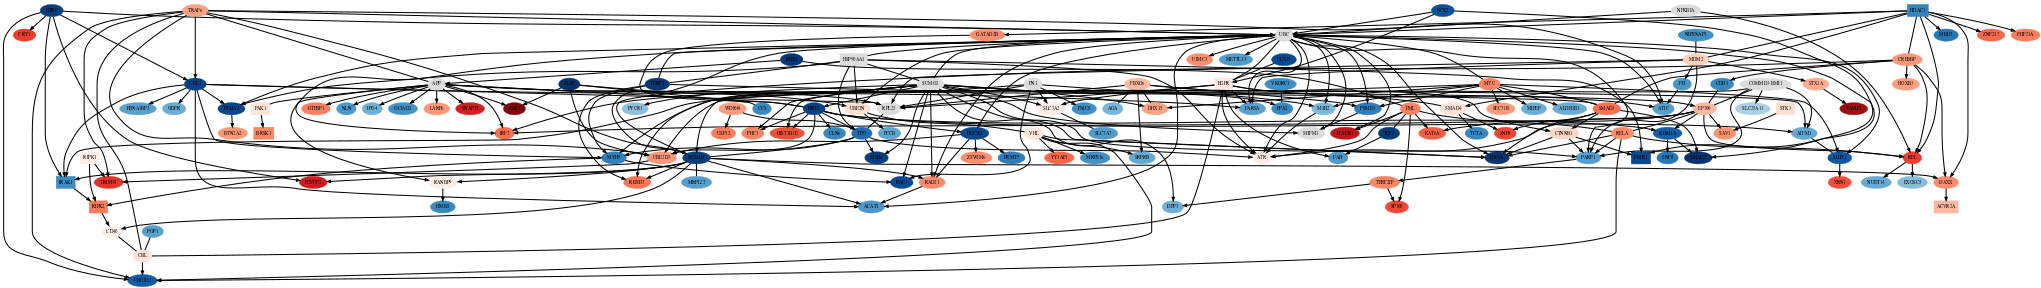

In [14]:
# display saved png image
Image(filename=fname_largest_cc)